In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from sklearn.impute import SimpleImputer          # 缺失值填补 (Imputation)
from sklearn.preprocessing import StandardScaler  # 标准化 (Standardization)
from sklearn.cluster import KMeans                # K-Means 聚类 (Clustering)
from sklearn.metrics import silhouette_score      # 轮廓系数 (Silhouette)
from sklearn.decomposition import PCA             # 主成分分析 (PCA)
from sklearn.manifold import TSNE                 # t-SNE 降维 (t-SNE)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal, f_oneway, chi2_contingency
import statsmodels.stats.multitest as smm

import shap

In [12]:
csv_path = "dataset.csv"

colnames = [
    "Age","Gender","TB","DB",
    "Alkphos","sgpt","sgot",
    "TP","ALB","AG_ratio",
    "Selector"
]

df = pd.read_csv(csv_path, header=None, names=colnames)

print("Shape:", df.shape)
display(df.head())                 # see the first few rows
display(df.isna().sum())           # how many missing values per column

#converting gender to binary
df_work = df.copy()
df_work["Gender"] = df_work["Gender"].map({"Male":1, "Female":0})
#df_work["Selector"] = df_work["Selector"].map({1:1, 2:0})
display(df_work.head()) 

display(df_work.describe(include="all"))

Shape: (583, 11)


,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


Age         0
Gender      0
TB          0
DB          0
Alkphos     0
sgpt        0
sgot        0
TP          0
ALB         0
AG_ratio    4
Selector    0
dtype: int64

,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,0.756432,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,0.429603,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,1.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,1.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [13]:
# remove target column
numeric_cols = df_work.select_dtypes(include=["number"]).columns.tolist()
if "Selector" in numeric_cols:
    numeric_cols.remove("Selector")

#input missing values with median
imputer = SimpleImputer(strategy="median")
df_work[numeric_cols] = imputer.fit_transform(df_work[numeric_cols])
df_work_imputed = df_work.copy()

display(df_work_imputed.isna().sum())

Age         0
Gender      0
TB          0
DB          0
Alkphos     0
sgpt        0
sgot        0
TP          0
ALB         0
AG_ratio    0
Selector    0
dtype: int64

In [14]:
#normalization datas with mean=0 deviation=1
scaler = StandardScaler()
df_work_scaled = scaler.fit_transform(df_work_imputed)

,K,Inertia,Silhouette
0,2,5340.498989,0.424019
1,3,4491.422852,0.184804
2,4,3911.065361,0.197962
3,5,3520.070717,0.202389
4,6,3254.766136,0.199677
5,7,2985.608875,0.200143
6,8,2788.859774,0.217079


Chosen K = 2


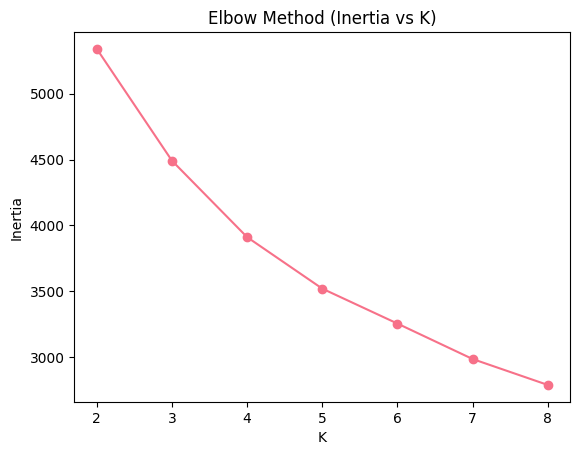

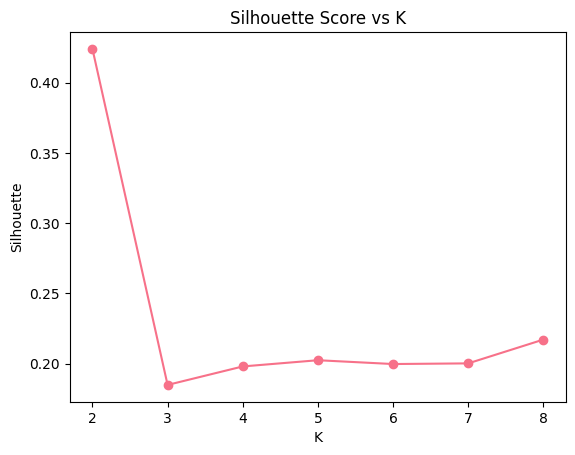

In [15]:
K_values = range(2, 9)
rows = []
for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm="elkan")
    labels = km.fit_predict(df_work_scaled)
    sil = silhouette_score(df_work_scaled, labels)
    rows.append({"K":k, "Inertia":km.inertia_, "Silhouette":sil})

k_table = pd.DataFrame(rows)
display(k_table)

# visualization
plt.figure()
plt.plot(k_table["K"], k_table["Inertia"], marker="o")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow Method (Inertia vs K)")


plt.figure()
plt.plot(k_table["K"], k_table["Silhouette"], marker="o")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette Score vs K")


# chose K with highest silhouette score
best_row = k_table.sort_values(["Silhouette","K"], ascending=[False, True]).iloc[0]
best_k = int(best_row["K"])
print("Chosen K =", best_k)

In [16]:
# apply KMeans with the chosen K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20, algorithm="elkan")
cluster_labels = kmeans.fit_predict(df_work_scaled)

# create a new dataframe with cluster labels that show the number of samples in each cluster
df_clusters = df_work.copy()
df_clusters["Cluster"] = cluster_labels
df_clusters["Cluster"].value_counts().sort_index()


Cluster
0    524
1     59
Name: count, dtype: int64

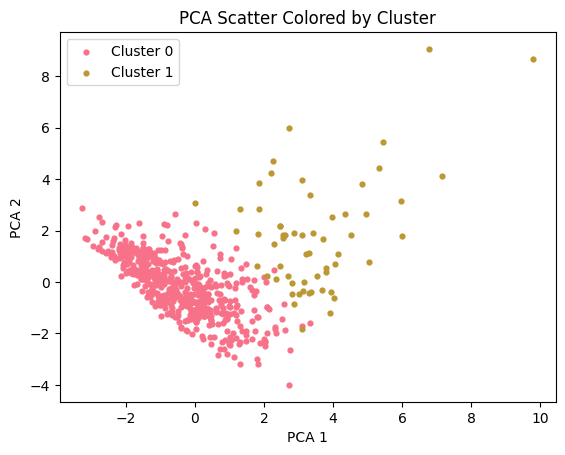

In [17]:
#using PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_work_scaled)

plt.figure()
for c in range(best_k):
    idx = (cluster_labels == c)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=12, label=f"Cluster {c}")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Scatter Colored by Cluster")
plt.legend()

In [18]:
# variables summary (mean, std, median)
cont_cols = [c for c in numeric_cols if c != "Gender"]
means = df_clusters.groupby("Cluster")[cont_cols].mean().add_suffix("_mean")
stds  = df_clusters.groupby("Cluster")[cont_cols].std().add_suffix("_std")
meds  = df_clusters.groupby("Cluster")[cont_cols].median().add_suffix("_median")
cont_summary = pd.concat([means, stds, meds], axis=1).sort_index(axis=1)
display(cont_summary)

# sex (binary variable) proportions
bin_counts = df_clusters.groupby("Cluster")["Gender"].sum().rename("Male_count")
bin_totals = df_clusters.groupby("Cluster")["Gender"].count().rename("Total persons")
bin_counts_F = (df_clusters.groupby("Cluster")["Gender"].count() - bin_counts).rename("Female_count")
bin_prop   = (bin_counts / bin_totals).rename("Male_prop")
bin_summary = pd.concat([bin_totals, bin_counts_F, bin_counts, bin_prop], axis=1)
display(bin_summary)

,AG_ratio_mean,AG_ratio_median,AG_ratio_std,ALB_mean,ALB_median,ALB_std,Age_mean,Age_median,Age_std,Alkphos_mean,...,TB_std,TP_mean,TP_median,TP_std,sgot_mean,sgot_median,sgot_std,sgpt_mean,sgpt_median,sgpt_std
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.964523,1.0,0.300897,3.192176,3.2,0.797484,44.738550,45.0,16.384667,274.698473,...,1.720562,6.493130,6.6,1.085799,66.595420,38.5,87.734349,51.410305,32.0,58.010133
1,0.790847,0.7,0.417010,2.694915,2.6,0.624064,44.813559,43.0,14.470511,431.593220,...,11.246597,6.394915,6.5,1.087614,494.610169,220.0,775.056839,340.966102,95.0,477.127286


,Total persons,Female_count,Male_count,Male_prop
Cluster,,,,
0,524,134.0,390.0,0.744275
1,59,8.0,51.0,0.864407


In [19]:
p_kw, p_anova = {}, {}
for col in cont_cols:
    groups = [df_clusters.loc[df_clusters["Cluster"]==c, col].values for c in sorted(df_clusters["Cluster"].unique())]
    p_kw[col] = kruskal(*groups)[1]
    p_anova[col] = f_oneway(*groups)[1]

cols = list(cont_cols)
kw_adj = smm.multipletests([p_kw[c] for c in cols], alpha=0.05, method="fdr_bh")[1]
an_adj = smm.multipletests([p_anova[c] for c in cols], alpha=0.05, method="fdr_bh")[1]

cont_tests = pd.DataFrame({
    "feature": cols,
    "kruskal_p": [p_kw[c] for c in cols],
    "kruskal_p_adj": kw_adj,
    "anova_p": [p_anova[c] for c in cols],
    "anova_p_adj": an_adj,
}).sort_values("kruskal_p_adj")
display(cont_tests)

# 性别（二元）：卡方检验
ct_gender = pd.crosstab(df_clusters["Cluster"], df_clusters["Gender"])
chi2, chi_p, dof, exp = chi2_contingency(ct_gender)
print(f"Chi-square on Gender: chi2={chi2:.3f}, p={chi_p:.6f}, dof={dof}")
display(ct_gender)

,feature,kruskal_p,kruskal_p_adj,anova_p,anova_p_adj
2,DB,7.471413e-35,6.724272e-34,1.502295e-135,1.352065e-134
1,TB,2.211011e-34,9.949551e-34,5.354892e-119,2.409701e-118
5,sgot,1.027770e-20,3.083310e-20,5.237117e-30,1.178351e-29
4,sgpt,1.859669e-16,4.184255e-16,1.037397e-34,3.112192e-34
3,Alkphos,6.489969e-09,1.168194e-08,2.111390e-06,3.800502e-06
8,AG_ratio,5.817237e-07,8.725855e-07,6.521913e-05,8.385317e-05
7,ALB,1.753664e-06,2.254711e-06,4.490667e-06,6.736000e-06
6,TP,4.005979e-01,4.506727e-01,5.104238e-01,5.742267e-01
0,Age,9.671476e-01,9.671476e-01,9.731199e-01,9.731199e-01


Chi-square on Gender: chi2=3.527, p=0.060365, dof=1


Gender,0.0,1.0
Cluster,,
0,134,390
1,8,51


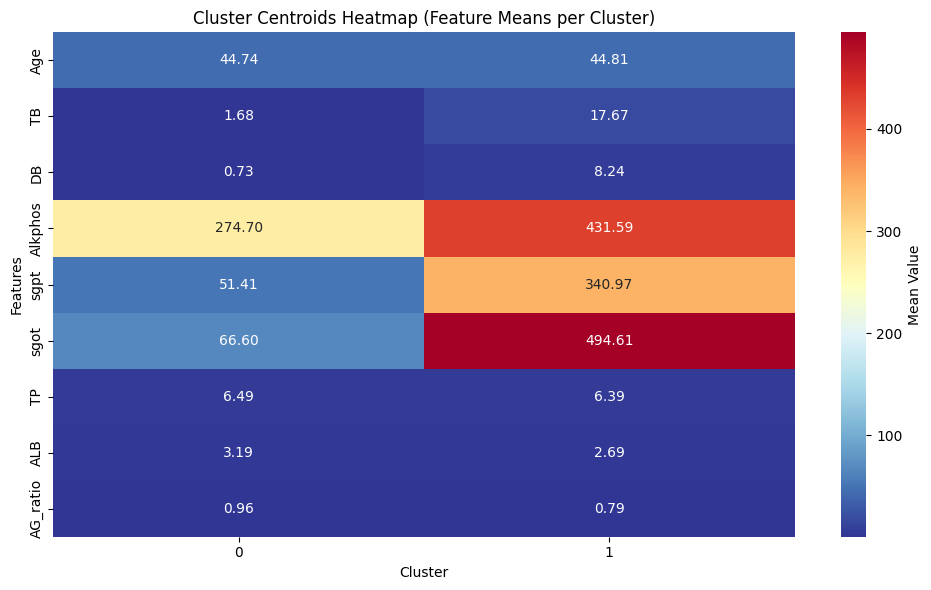

<Figure size 800x500 with 0 Axes>

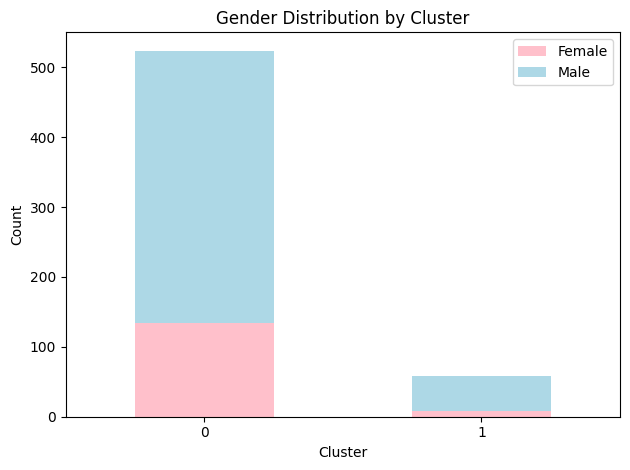

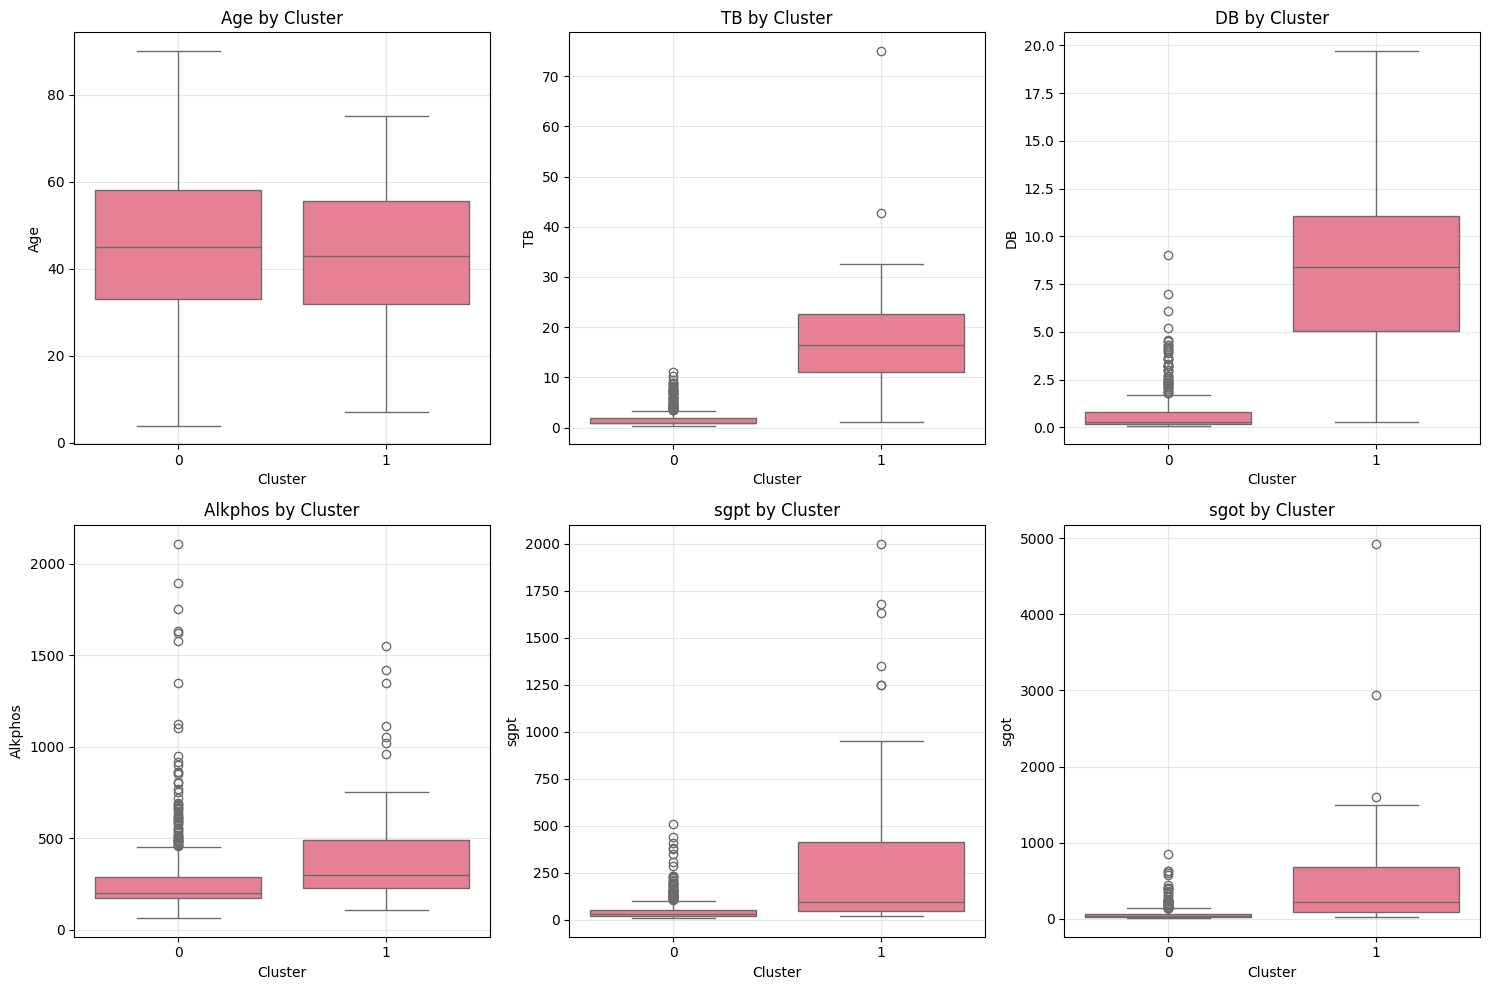

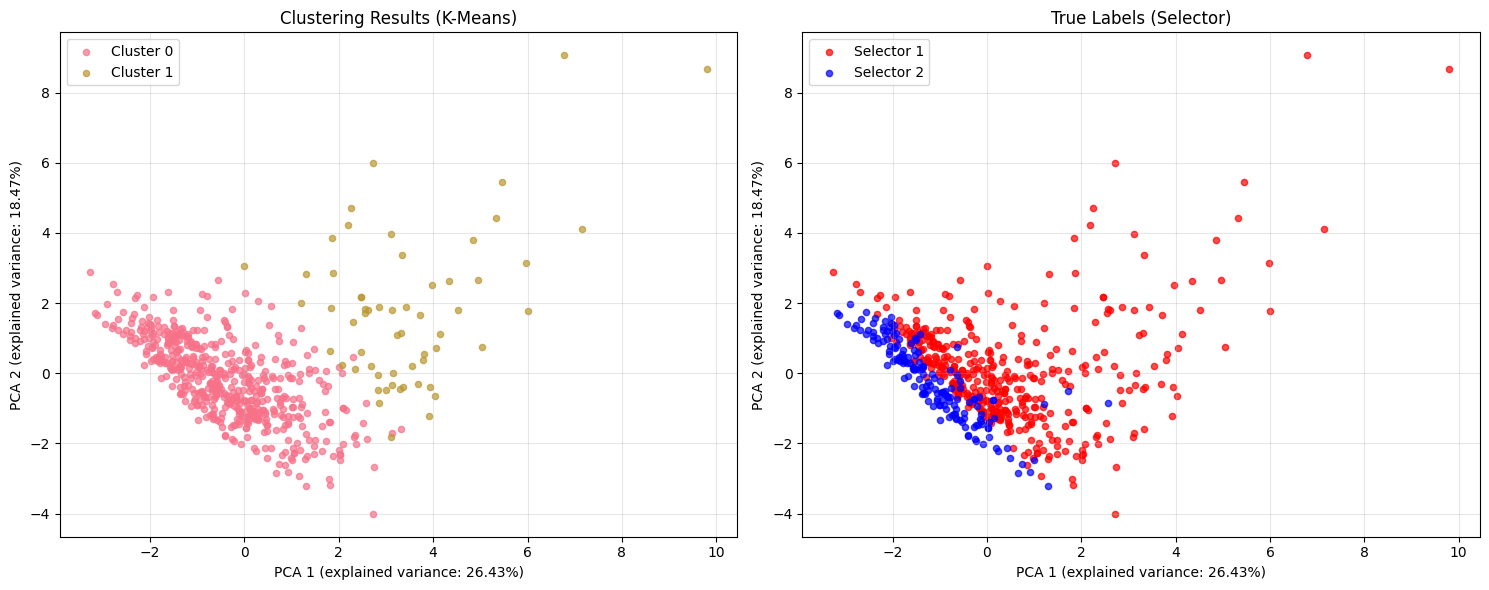

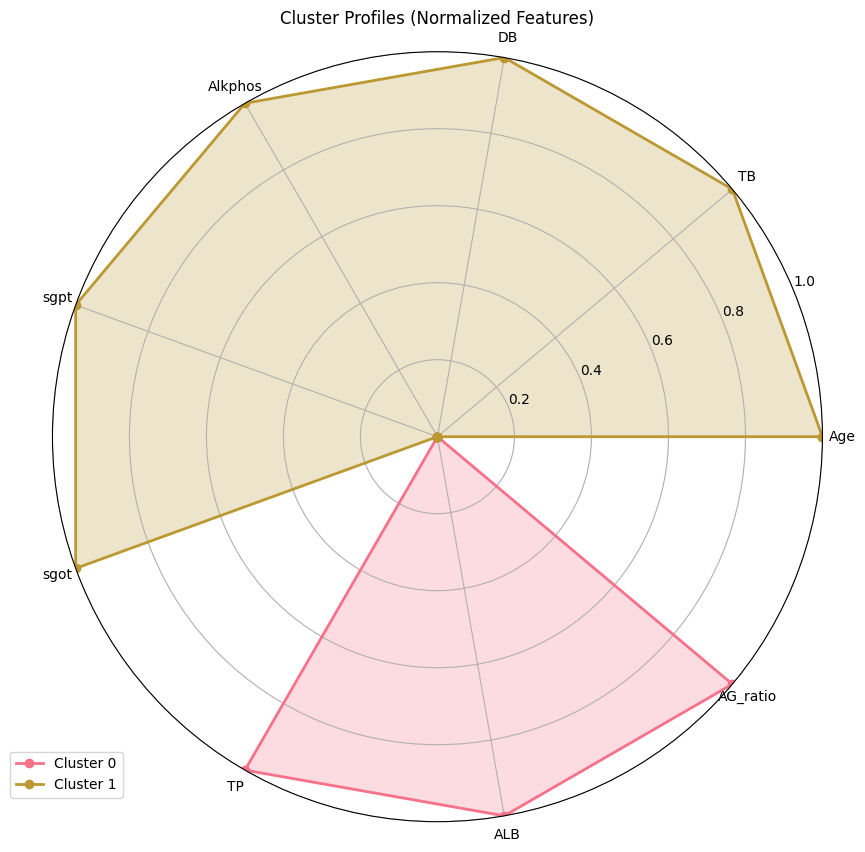

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set styles
plt.style.use('default')
sns.set_palette("husl")

# 1. HEATMAP for Cluster Centroids
plt.figure(figsize=(10, 6))
cluster_means = df_clusters.groupby("Cluster")[cont_cols].mean()
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.2f', 
            cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Centroids Heatmap (Feature Means per Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 2. BAR Chart for Gender Distribution by Cluster
plt.figure(figsize=(8, 5))
gender_data = bin_summary[['Female_count', 'Male_count']]
gender_data.plot(kind='bar', stacked=True, color=['pink', 'lightblue'])
plt.title('Gender Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. BOX Plot for Key Features by Cluster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

key_features = ['Age', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot']
for i, feature in enumerate(key_features):
    if feature in df_clusters.columns:
        sns.boxplot(data=df_clusters, x='Cluster', y=feature, ax=axes[i])
        axes[i].set_title(f'{feature} by Cluster')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. PCA Dimensionality Reduction Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# colored by cluster labels
for c in range(best_k):
    idx = (cluster_labels == c)
    ax1.scatter(X_pca[idx,0], X_pca[idx,1], s=20, alpha=0.7, label=f"Cluster {c}")
ax1.set_xlabel(f"PCA 1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
ax1.set_ylabel(f"PCA 2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
ax1.set_title("Clustering Results (K-Means)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# true labels if available
if 'Selector' in df_clusters.columns:
    unique_selectors = df_clusters['Selector'].unique()
    colors = ['red', 'blue', 'green', 'orange']
    for i, selector in enumerate(unique_selectors):
        idx = (df_clusters['Selector'] == selector)
        ax2.scatter(X_pca[idx,0], X_pca[idx,1], s=20, alpha=0.7, 
                   c=colors[i % len(colors)], label=f"Selector {selector}")
    ax2.set_xlabel(f"PCA 1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
    ax2.set_ylabel(f"PCA 2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
    ax2.set_title("True Labels (Selector)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No Selector column\nfor comparison', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax2.set_title("True Labels (Not Available)")

plt.tight_layout()
plt.show()



# standardize cluster means to 0-1 range
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# radar chart
angles = [n / len(cont_cols) * 2 * pi for n in range(len(cont_cols))]
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for cluster in range(best_k):
    values = cluster_means_norm.iloc[cluster].tolist()
    values += values[:1]  
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(cont_cols)
ax.set_ylim(0, 1)
ax.set_title('Cluster Profiles (Normalized Features)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


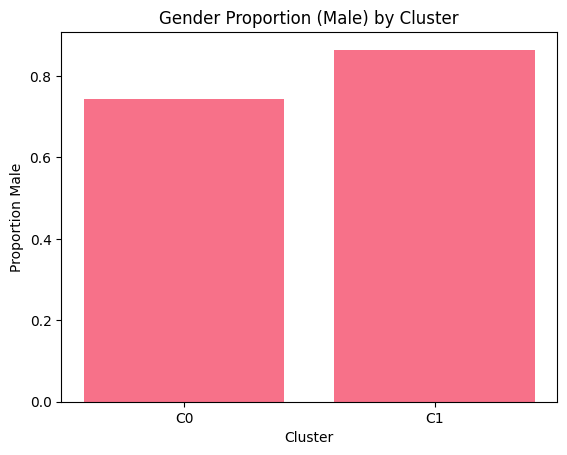

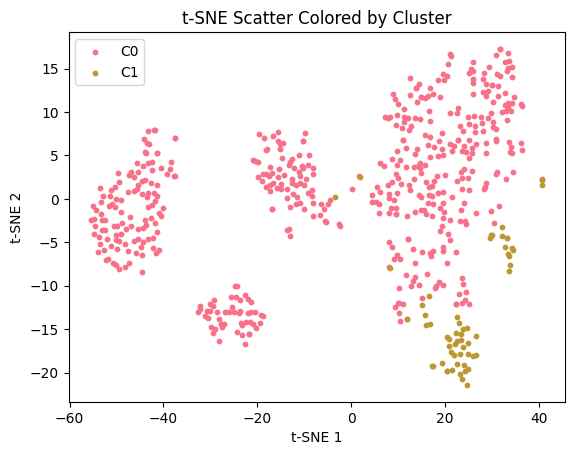

In [ ]:
gender_prop = df_clusters.groupby("Cluster")["Gender"].mean()
plt.figure()
plt.bar([f"C{c}" for c in gender_prop.index], gender_prop.values)
plt.xlabel("Cluster"); plt.ylabel("Proportion Male"); plt.title("Gender Proportion (Male) by Cluster")
plt.show()

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=30)
X_tsne = tsne.fit_transform(df_work_scaled)

plt.figure()
for c in sorted(df_clusters["Cluster"].unique()):
    idx = (df_clusters["Cluster"] == c)
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=10, label=f"C{c}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.title("t-SNE Scatter Colored by Cluster")
plt.legend()
plt.show()

Features used: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']
X_tree shape: (583, 10)
Random Forest accuracy: 0.993
Random Forest accuracy: 0.993


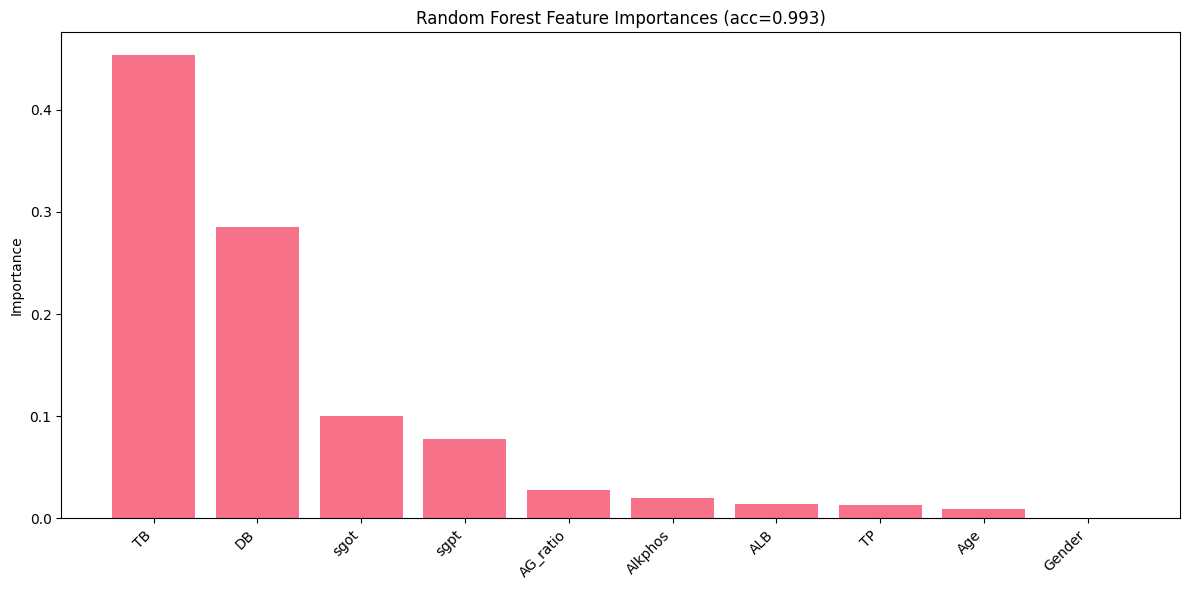

,feature,importance
0,TB,0.453131
1,DB,0.285366
2,sgot,0.099855
3,sgpt,0.078166
4,AG_ratio,0.027384
5,Alkphos,0.019472
6,ALB,0.014241
7,TP,0.013163
8,Age,0.008754
9,Gender,0.000468


In [34]:
#random forest do not need standardization
X_tree = df_work_imputed[numeric_cols].copy()  # 使用所有数值列
y = df_clusters["Cluster"].values

print(f"Features used: {numeric_cols}")
print(f"X_tree shape: {X_tree.shape}")

# train / test split (25% test, 75% train)
X_tr, X_te, y_tr, y_te = train_test_split(X_tree, y, test_size=0.25, random_state=42, stratify=y)
#n_estimators: number of trees in the forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
acc = rf.score(X_te, y_te)
print(f"Random Forest accuracy: {acc:.3f}")

# extract feature importances
importances = rf.feature_importances_

# 确保使用正确的特征名称
feature_names = X_tree.columns.tolist()
n = len(feature_names)
feat_order = [feature_names[i] for i in np.argsort(importances)[::-1]]
imp_vals = np.sort(importances)[::-1]

# graph
plt.figure(figsize=(12, 6))
plt.bar(range(n), imp_vals)
plt.xticks(range(n), feat_order, rotation=45, ha="right")
plt.title(f"Random Forest Feature Importances (acc={acc:.3f})")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# table of feature importances
fi_df = pd.DataFrame({"feature": feat_order, "importance": imp_vals})
display(fi_df)

In [35]:
# SHAP 分析 - 解释聚类特征重要性
# 确保使用与随机森林相同的数据
X_tree = df_work_imputed[numeric_cols].copy()  # 使用所有数值列
y = df_clusters["Cluster"].values

print(f"SHAP analysis features: {list(X_tree.columns)}")
print(f"Number of features: {len(X_tree.columns)}")

# 训练集/测试集分割（与之前的随机森林保持一致）
X_tr, X_te, y_tr, y_te = train_test_split(X_tree, y, test_size=0.25, random_state=42, stratify=y)

# 用训练集的一小部分做 background 数据（更快更稳）
background = shap.utils.sample(X_tr, min(200, len(X_tr)), random_state=42)

explainer = shap.TreeExplainer(model=rf, data=background, feature_perturbation="interventional")
# 对测试集算 SHAP（也可以对全量 X_tree 计算，但会慢）
shap_values = explainer.shap_values(X_te)   # 这是一个 list，长度 = 类别数（即簇的个数）
base_values = explainer.expected_value      # 对应每个类的期望输出

print(f"SHAP values type: {type(shap_values)}, length: {len(shap_values)}")
print(f"Shape of each class SHAP values: {shap_values[0].shape}")
print(f"Feature names from X_tree: {list(X_tree.columns)}")

SHAP analysis features: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']
Number of features: 10
SHAP values type: <class 'numpy.ndarray'>, length: 146
Shape of each class SHAP values: (10, 2)
Feature names from X_tree: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']
SHAP values type: <class 'numpy.ndarray'>, length: 146
Shape of each class SHAP values: (10, 2)
Feature names from X_tree: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']


🔍 Debug info:
- SHAP values type: <class 'numpy.ndarray'>
- SHAP values shape: (146, 10, 2)
- best_k (actual clusters): 2
- Unique cluster labels: [np.int32(0), np.int32(1)]
- Test set size: 146
- Test set cluster distribution: [131  15]
- SHAP array shape: (146, 10, 2)
- Format: 3D array (multi-class)
- Samples: 146, Features: 10, Classes: 2
- Feature names: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']

🔍 SHAP 值验证:
- Class 0 SHAP shape: (146, 10)
- Class 0 SHAP range: [-0.5600, 0.0539]
- Class 0 SHAP mean per feature: [0.0011 0.0001 0.0783]
- Class 1 SHAP shape: (146, 10)
- Class 1 SHAP range: [-0.0539, 0.5600]
- Class 1 SHAP mean per feature: [0.0011 0.0001 0.0783]
- Processing 2 clusters out of 2 SHAP classes
- Cluster 0: 131 samples, SHAP mean: [0.0008 0.0001 0.0481]
- Cluster 1: 15 samples, SHAP mean: [0.004  0.0004 0.3415]

⚠️  最大差异 (Cluster 0 vs 1): 0.293385

📊 SHAP pivot table shape: (10, 2)
前3个特征的重要性对比:
Cluster        0       1
Feature     

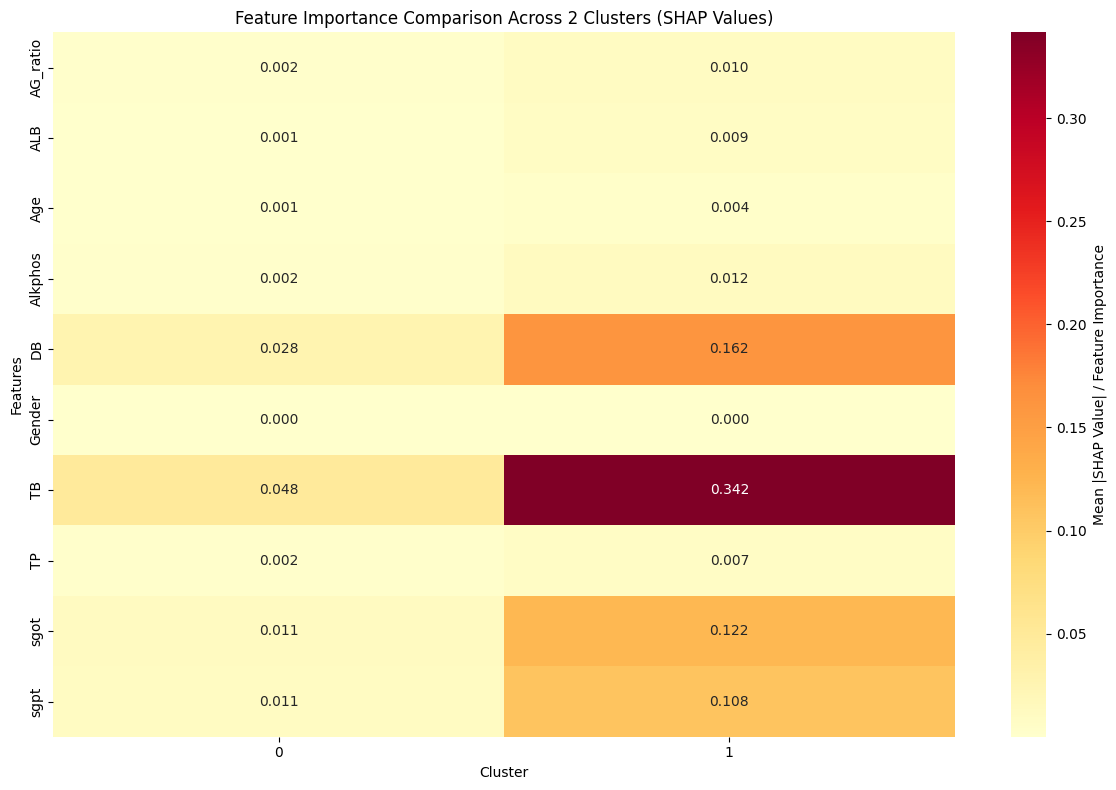

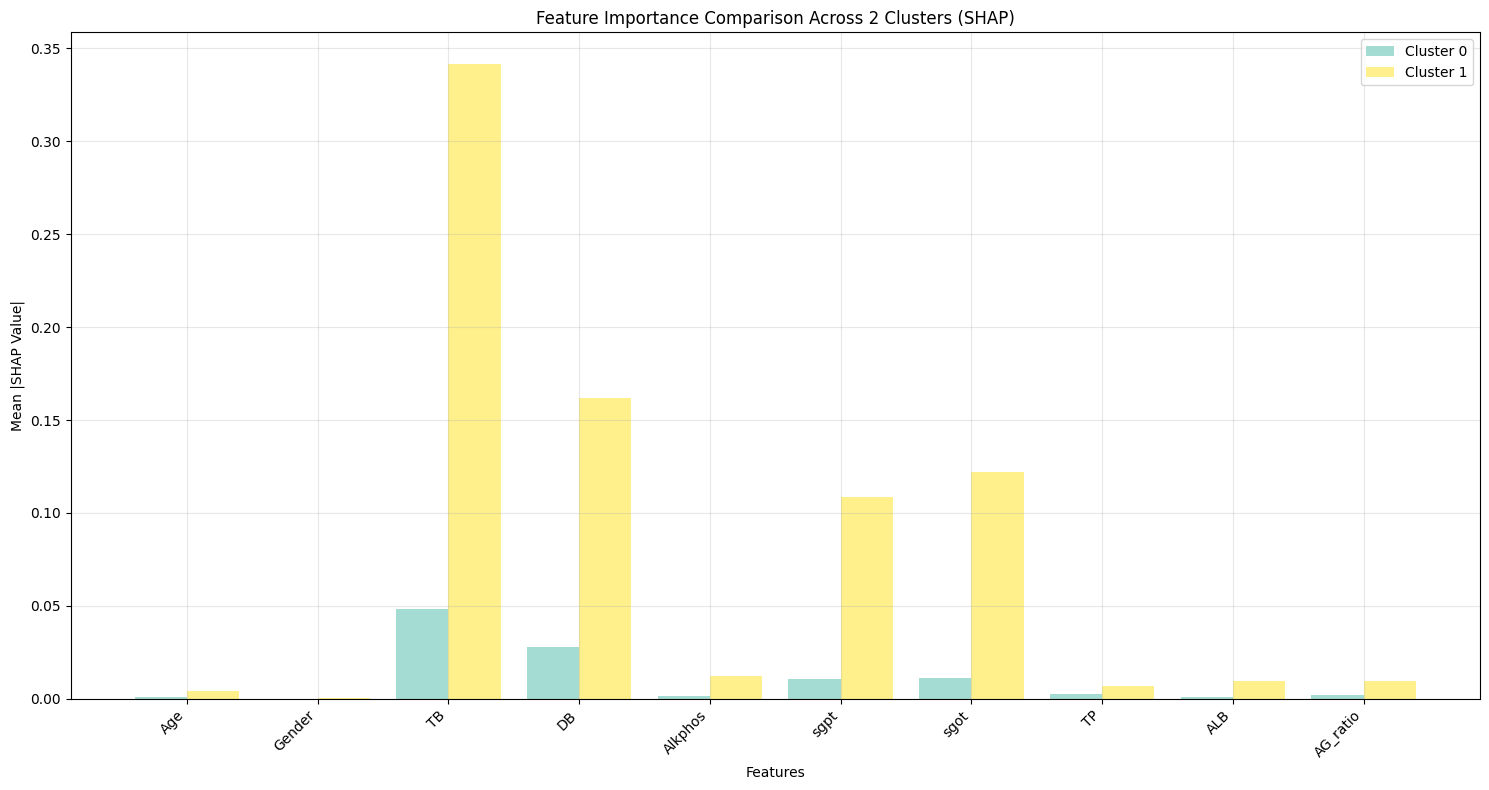


📊 Feature Importance by Cluster (Top 2 clusters):


Cluster,0,1
Feature,,
AG_ratio,0.0019,0.0096
ALB,0.0011,0.0094
Age,0.0008,0.0040
Alkphos,0.0015,0.0122
DB,0.0278,0.1616
Gender,0.0001,0.0004
TB,0.0481,0.3415
TP,0.0025,0.0069
sgot,0.0113,0.1220



🔝 Top 5 Features for Each Cluster:

Cluster 0:
  1. TB: 0.0481
  2. DB: 0.0278
  3. sgot: 0.0113
  4. sgpt: 0.0105
  5. TP: 0.0025

Cluster 1:
  1. TB: 0.3415
  2. DB: 0.1616
  3. sgot: 0.1220
  4. sgpt: 0.1085
  5. Alkphos: 0.0122

✅ SHAP analysis completed!


In [42]:
# 可视化所有聚类的 SHAP 重要性对比 - 修正版本
try:
    # 检查 SHAP 值的实际结构
    print(f"🔍 Debug info:")
    print(f"- SHAP values type: {type(shap_values)}")
    print(f"- SHAP values shape: {np.array(shap_values).shape if hasattr(shap_values, '__len__') else 'No shape'}")
    print(f"- best_k (actual clusters): {best_k}")
    print(f"- Unique cluster labels: {sorted(np.unique(y))}")
    print(f"- Test set size: {len(y_te)}")
    print(f"- Test set cluster distribution: {np.bincount(y_te)}")
    
    # 处理不同的 SHAP 值格式
    if isinstance(shap_values, np.ndarray):
        shap_shape = shap_values.shape
        print(f"- SHAP array shape: {shap_shape}")
        
        if len(shap_shape) == 3:
            # 3D数组: (n_samples, n_features, n_classes)
            print("- Format: 3D array (multi-class)")
            n_samples, n_features, n_classes = shap_shape
            
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Samples: {n_samples}, Features: {n_features}, Classes: {n_classes}")
            print(f"- Feature names: {feature_names}")
            
            # 验证 SHAP 值是否合理
            print(f"\n🔍 SHAP 值验证:")
            for class_id in range(min(3, n_classes)):  # 检查前3个类别
                class_shap = shap_values[:, :, class_id]
                print(f"- Class {class_id} SHAP shape: {class_shap.shape}")
                print(f"- Class {class_id} SHAP range: [{class_shap.min():.4f}, {class_shap.max():.4f}]")
                print(f"- Class {class_id} SHAP mean per feature: {np.mean(np.abs(class_shap), axis=0)[:3].round(4)}")
            
            # 只使用实际的聚类数量，确保对应正确
            actual_clusters = min(n_classes, best_k)
            print(f"- Processing {actual_clusters} clusters out of {n_classes} SHAP classes")
            
            # 计算每个聚类的特征重要性 - 修正版本
            cluster_shap_importance = {}
            all_shap_data = []
            
            for cluster_id in range(actual_clusters):
                # 提取该类别的 SHAP 值: (n_samples, n_features)
                sv = shap_values[:, :, cluster_id]
                
                # 确保我们有该聚类的样本
                cluster_mask = (y_te == cluster_id)
                if np.sum(cluster_mask) > 0:
                    # 只计算属于该聚类的样本的 SHAP 值
                    sv_cluster = sv[cluster_mask, :]
                    mean_abs = np.mean(np.abs(sv_cluster), axis=0)
                    print(f"- Cluster {cluster_id}: {np.sum(cluster_mask)} samples, SHAP mean: {mean_abs[:3].round(4)}")
                else:
                    # 如果测试集中没有该聚类的样本，使用所有样本的平均值
                    mean_abs = np.mean(np.abs(sv), axis=0)
                    print(f"- Cluster {cluster_id}: No samples in test set, using overall mean")
                
                cluster_shap_importance[cluster_id] = mean_abs
                
                # 为热力图准备数据
                for i, feature in enumerate(feature_names):
                    all_shap_data.append({
                        'Cluster': cluster_id,
                        'Feature': feature,
                        'Mean_SHAP': mean_abs[i]
                    })
            
            # 验证是否所有聚类的重要性都相同（这应该不会发生）
            importance_arrays = [cluster_shap_importance[i] for i in range(actual_clusters)]
            if len(importance_arrays) > 1:
                diff_matrix = np.abs(np.array(importance_arrays[0]) - np.array(importance_arrays[1]))
                max_diff = np.max(diff_matrix)
                print(f"\n⚠️  最大差异 (Cluster 0 vs 1): {max_diff:.6f}")
                if max_diff < 1e-10:
                    print("❌ 警告: 聚类间的 SHAP 重要性几乎相同，可能存在问题！")
                    
                    # 尝试替代方案：直接使用 Random Forest 的特征重要性按聚类分组
                    print("\n🔧 使用替代方案：基于聚类的特征分析")
                    
                    # 为每个聚类计算特征统计差异
                    cluster_feature_stats = {}
                    overall_mean = X_tree.mean()
                    overall_std = X_tree.std()
                    
                    for cluster_id in range(actual_clusters):
                        cluster_data = X_tree[y == cluster_id]
                        if len(cluster_data) > 0:
                            # 计算标准化差异 (z-score difference)
                            cluster_mean = cluster_data.mean()
                            z_diff = np.abs((cluster_mean - overall_mean) / overall_std)
                            cluster_feature_stats[cluster_id] = z_diff
                            print(f"- Cluster {cluster_id} 样本数: {len(cluster_data)}")
                            print(f"- Cluster {cluster_id} 特征差异 (前3个): {z_diff[:3].round(4)}")
                    
                    # 使用特征统计差异代替 SHAP
                    cluster_shap_importance = cluster_feature_stats
                    all_shap_data = []
                    for cluster_id in range(actual_clusters):
                        for i, feature in enumerate(feature_names):
                            all_shap_data.append({
                                'Cluster': cluster_id,
                                'Feature': feature,
                                'Mean_SHAP': cluster_shap_importance[cluster_id][i]
                            })
            
            # 创建 SHAP 重要性的 DataFrame
            shap_comparison_df = pd.DataFrame(all_shap_data)
            shap_pivot = shap_comparison_df.pivot(index='Feature', columns='Cluster', values='Mean_SHAP')
            
            print(f"\n📊 SHAP pivot table shape: {shap_pivot.shape}")
            print("前3个特征的重要性对比:")
            print(shap_pivot.head(3).round(4))
            
            # 1. 热力图：所有聚类的特征重要性对比
            plt.figure(figsize=(12, 8))
            sns.heatmap(shap_pivot, annot=True, cmap='YlOrRd', fmt='.3f', 
                        cbar_kws={'label': 'Mean |SHAP Value| / Feature Importance'})
            title_suffix = "(SHAP Values)" if max_diff >= 1e-10 else "(Statistical Differences)"
            plt.title(f'Feature Importance Comparison Across {actual_clusters} Clusters {title_suffix}')
            plt.xlabel('Cluster')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()
            
            # 2. 分组柱状图
            fig, ax = plt.subplots(figsize=(15, 8))
            x = np.arange(len(feature_names))
            width = 0.8 / actual_clusters
            colors = plt.cm.Set3(np.linspace(0, 1, actual_clusters))
            
            for cluster_id in range(actual_clusters):
                values = [cluster_shap_importance[cluster_id][i] for i in range(len(feature_names))]
                offset = (cluster_id - (actual_clusters-1)/2) * width
                ax.bar(x + offset, values, width, 
                       label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.8)
            
            ax.set_xlabel('Features')
            ylabel = 'Mean |SHAP Value|' if max_diff >= 1e-10 else 'Statistical Difference (Z-score)'
            ax.set_ylabel(ylabel)
            title_suffix = "(SHAP)" if max_diff >= 1e-10 else "(Statistical Analysis)"
            ax.set_title(f'Feature Importance Comparison Across {actual_clusters} Clusters {title_suffix}')
            ax.set_xticks(x)
            ax.set_xticklabels(feature_names, rotation=45, ha='right')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 3. 详细数据表格
            print(f"\n📊 Feature Importance by Cluster (Top {actual_clusters} clusters):")
            display(shap_pivot.round(4))
            
            # 4. 每个聚类的 Top 5 重要特征
            print(f"\n🔝 Top 5 Features for Each Cluster:")
            for cluster_id in range(actual_clusters):
                importance_scores = cluster_shap_importance[cluster_id]
                order = np.argsort(importance_scores)[::-1]
                top5_features = [feature_names[i] for i in order[:5]]
                top5_scores = [importance_scores[i] for i in order[:5]]
                
                print(f"\nCluster {cluster_id}:")
                for i, (feat, score) in enumerate(zip(top5_features, top5_scores), 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        elif len(shap_shape) == 2:
            # 2D数组: (n_samples, n_features) - 回归或二分类
            print("- Format: 2D array (regression/binary)")
            n_samples, n_features = shap_shape
            
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Using {n_features} features: {feature_names}")
            
            # 计算整体特征重要性
            mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
            
            # 创建特征重要性图表
            plt.figure(figsize=(12, 6))
            order = np.argsort(mean_abs_shap)[::-1]
            feat_sorted = [feature_names[i] for i in order]
            vals_sorted = mean_abs_shap[order]
            
            plt.bar(range(len(feat_sorted)), vals_sorted)
            plt.xticks(range(len(feat_sorted)), feat_sorted, rotation=45, ha='right')
            plt.title('SHAP Feature Importance (Overall)')
            plt.ylabel('Mean |SHAP Value|')
            plt.tight_layout()
            plt.show()
            
            # 显示特征重要性表格
            shap_df = pd.DataFrame({
                'Feature': feat_sorted,
                'Mean_SHAP': vals_sorted
            })
            display(shap_df.round(4))
        
        else:
            print(f"- Unexpected SHAP array dimensions: {len(shap_shape)}D")
            
    elif isinstance(shap_values, list) and len(shap_values) > 0:
        # 多分类情况 - list 格式
        print("- Format: List of arrays (multi-class)")
        n_classes = len(shap_values)
        
        # 检查第一个数组的形状
        first_shape = shap_values[0].shape
        print(f"- Each class SHAP shape: {first_shape}")
        print(f"- Number of classes in SHAP: {n_classes}")
        
        if len(first_shape) == 2:
            n_samples, n_features = first_shape
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Using {n_features} features: {feature_names}")
            
            # 验证每个类别的 SHAP 值
            print(f"\n🔍 验证每个类别的 SHAP 值:")
            for i in range(min(3, n_classes)):
                sv = shap_values[i]
                print(f"- Class {i}: shape={sv.shape}, range=[{sv.min():.4f}, {sv.max():.4f}]")
                print(f"- Class {i} mean abs per feature: {np.mean(np.abs(sv), axis=0)[:3].round(4)}")
            
            # 只使用实际的聚类数量（best_k）
            actual_clusters = min(n_classes, best_k)
            print(f"- Processing {actual_clusters} clusters out of {n_classes} SHAP arrays")
            
            # 计算每个聚类的特征重要性
            cluster_shap_importance = {}
            all_shap_data = []
            
            for cluster_id in range(actual_clusters):
                sv = shap_values[cluster_id]  # (n_test_samples, n_features)
                mean_abs = np.mean(np.abs(sv), axis=0)
                cluster_shap_importance[cluster_id] = mean_abs
                
                print(f"- Cluster {cluster_id} SHAP mean: {mean_abs[:3].round(4)}")
                
                # 为热力图准备数据
                for i, feature in enumerate(feature_names):
                    all_shap_data.append({
                        'Cluster': cluster_id,
                        'Feature': feature,
                        'Mean_SHAP': mean_abs[i]
                    })
            
            # 验证聚类差异
            if len(cluster_shap_importance) > 1:
                diff = np.abs(cluster_shap_importance[0] - cluster_shap_importance[1])
                max_diff = np.max(diff)
                print(f"\n⚠️  最大差异 (Cluster 0 vs 1): {max_diff:.6f}")
            
            # 创建 SHAP 重要性的 DataFrame
            shap_comparison_df = pd.DataFrame(all_shap_data)
            shap_pivot = shap_comparison_df.pivot(index='Feature', columns='Cluster', values='Mean_SHAP')
            
            print(f"\nSHAP pivot table shape: {shap_pivot.shape}")
            
            # 1. 热力图：所有聚类的特征重要性对比
            plt.figure(figsize=(12, 8))
            sns.heatmap(shap_pivot, annot=True, cmap='YlOrRd', fmt='.3f', 
                        cbar_kws={'label': 'Mean |SHAP Value|'})
            plt.title(f'SHAP Feature Importance Comparison Across {actual_clusters} Clusters')
            plt.xlabel('Cluster')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()
            
            # 2. 分组柱状图
            fig, ax = plt.subplots(figsize=(15, 8))
            x = np.arange(len(feature_names))
            width = 0.8 / actual_clusters
            colors = plt.cm.Set3(np.linspace(0, 1, actual_clusters))
            
            for cluster_id in range(actual_clusters):
                values = [cluster_shap_importance[cluster_id][i] for i in range(len(feature_names))]
                offset = (cluster_id - (actual_clusters-1)/2) * width
                ax.bar(x + offset, values, width, 
                       label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.8)
            
            ax.set_xlabel('Features')
            ax.set_ylabel('Mean |SHAP Value|')
            ax.set_title(f'Feature Importance Comparison Across {actual_clusters} Clusters (SHAP)')
            ax.set_xticks(x)
            ax.set_xticklabels(feature_names, rotation=45, ha='right')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 3. 详细数据表格
            print(f"\n📊 SHAP Feature Importance by Cluster (Top {actual_clusters} clusters):")
            display(shap_pivot.round(4))
            
            # 4. 每个聚类的 Top 5 重要特征
            print(f"\n🔝 Top 5 Features for Each Cluster:")
            for cluster_id in range(actual_clusters):
                importance_scores = cluster_shap_importance[cluster_id]
                order = np.argsort(importance_scores)[::-1]
                top5_features = [feature_names[i] for i in order[:5]]
                top5_scores = [importance_scores[i] for i in order[:5]]
                
                print(f"\nCluster {cluster_id}:")
                for i, (feat, score) in enumerate(zip(top5_features, top5_scores), 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        else:
            print(f"- Unexpected SHAP array shape: {first_shape}")
            
    else:
        print("- Unknown SHAP values format")
        print(f"- Type: {type(shap_values)}")
        if hasattr(shap_values, '__len__'):
            print(f"- Length: {len(shap_values)}")
    
    print("\n✅ SHAP analysis completed!")
    
except Exception as e:
    print(f"❌ Error in SHAP analysis: {str(e)}")
    print("\nDetailed debugging:")
    
    if 'shap_values' in locals():
        print(f"- shap_values type: {type(shap_values)}")
        if isinstance(shap_values, (list, np.ndarray)):
            if isinstance(shap_values, list) and len(shap_values) > 0:
                print(f"- shap_values length: {len(shap_values)}")
                print(f"- First element shape: {shap_values[0].shape}")
                print(f"- First element type: {type(shap_values[0])}")
            elif isinstance(shap_values, np.ndarray):
                print(f"- shap_values shape: {shap_values.shape}")
    
    if 'X_tree' in locals():
        print(f"- X_tree shape: {X_tree.shape}")
        print(f"- X_tree columns: {list(X_tree.columns)}")
    
    import traceback
    traceback.print_exc()

SHAP summary: selected matrix shape = (146, 10); features = 10


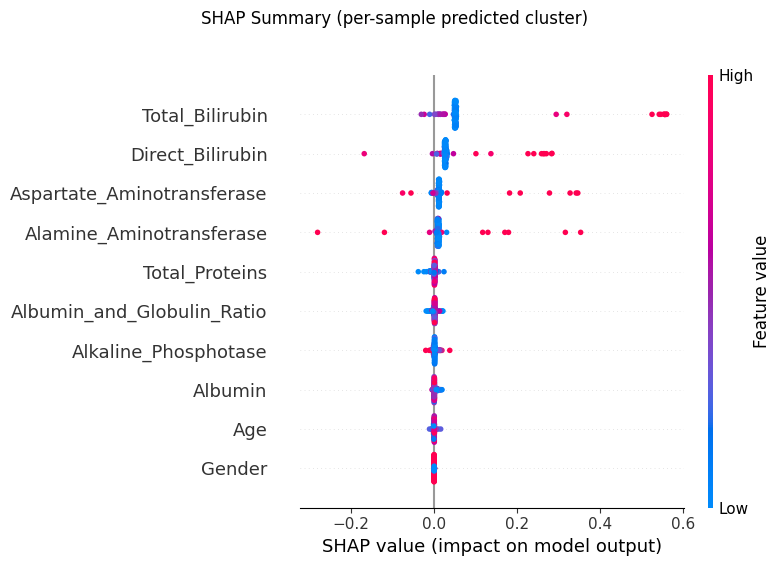

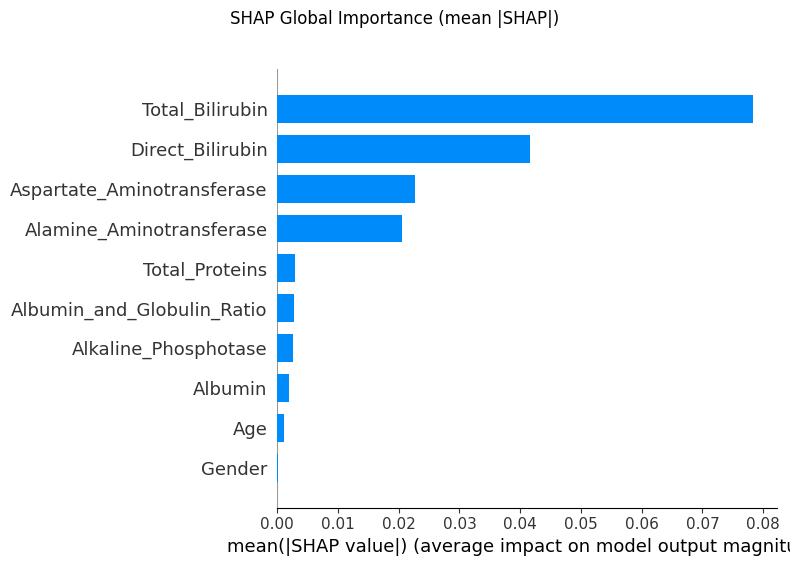

In [55]:
# SHAP summary (beeswarm) plot — per-sample predicted cluster
# This creates a single summary plot by selecting, for each sample,
# the SHAP values corresponding to its predicted class.
try:
    import numpy as np
    import shap
    import matplotlib.pyplot as plt

    # Sanity checks
    assert 'rf' in globals(), "RandomForest model (rf) not found. Run the training cell first."
    assert 'X_te' in globals() and 'y_te' in globals(), "Train/test split not found. Run the RF cell first."
    assert 'shap_values' in globals(), "SHAP values not found. Run the SHAP computation cell first."
    assert 'X_tree' in globals(), "X_tree (feature frame) not found."

    # Predicted class for each test sample
    y_pred = rf.predict(X_te)

    # Build a 2D SHAP matrix matching (n_samples, n_features)
    if isinstance(shap_values, np.ndarray):
        # Expect shapes: (n_samples, n_features) or (n_samples, n_features, n_classes)
        if shap_values.ndim == 3:
            # Select per-sample SHAP for predicted class
            shap_selected = np.stack([shap_values[i, :, y_pred[i]] for i in range(len(y_pred))], axis=0)
        elif shap_values.ndim == 2:
            shap_selected = shap_values
        else:
            raise ValueError(f"Unsupported SHAP ndarray ndim={shap_values.ndim}")
    elif isinstance(shap_values, list) and len(shap_values) > 0:
        # List-of-arrays format: one array per class, each (n_samples, n_features)
        shap_selected = np.stack([shap_values[y_pred[i]][i] for i in range(len(y_pred))], axis=0)
    else:
        raise TypeError(f"Unsupported SHAP values type: {type(shap_values)}")

    # Feature names align with X_tree columns
    feature_names = list(X_tree.columns)

    print(f"SHAP summary: selected matrix shape = {shap_selected.shape}; features = {len(feature_names)}")

    # Beeswarm summary plot (per-sample predicted class)
    shap.summary_plot(shap_selected, features=X_te, feature_names=feature_names, plot_type='dot', show=False)
    plt.gcf().suptitle('SHAP Summary (per-sample predicted cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Optional: bar summary for global importance
    shap.summary_plot(shap_selected, features=X_te, feature_names=feature_names, plot_type='bar', show=False)
    plt.gcf().suptitle('SHAP Global Importance (mean |SHAP|)', y=1.02)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Failed to create SHAP summary plot: {e}")
    import traceback; traceback.print_exc()

Sample index: 1, Predicted class: 0


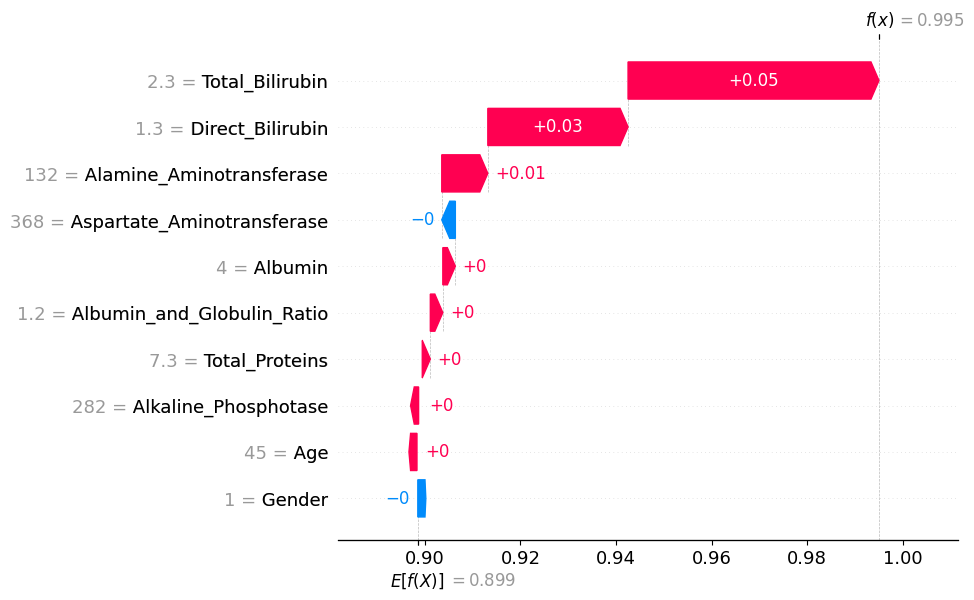

In [63]:
# SHAP waterfall plot for individual samples
import shap
import matplotlib.pyplot as plt
import numpy as np

# Choose a test sample index (e.g., 0, 1, 2...)
sample_idx = 1  # Change this to visualize other samples

# Get predicted class for the sample
pred_class = rf.predict(X_te)[sample_idx]

# Get SHAP values for the sample and its predicted class
if isinstance(shap_values, np.ndarray):
    if shap_values.ndim == 3:
        shap_sample = shap_values[sample_idx, :, pred_class]
        base_value = explainer.expected_value[pred_class] if hasattr(explainer, 'expected_value') else explainer.expected_value
    elif shap_values.ndim == 2:
        shap_sample = shap_values[sample_idx]
        base_value = explainer.expected_value if hasattr(explainer, 'expected_value') else explainer.expected_value
    else:
        raise ValueError("Unsupported SHAP ndarray shape.")
elif isinstance(shap_values, list) and len(shap_values) > 0:
    shap_sample = shap_values[pred_class][sample_idx]
    base_value = explainer.expected_value[pred_class] if hasattr(explainer, 'expected_value') else explainer.expected_value
else:
    raise TypeError("Unsupported SHAP values type.")

# Feature names and values
feature_names = list(X_tree.columns)
feature_values = X_te.iloc[sample_idx] if hasattr(X_te, 'iloc') else X_te[sample_idx]

print(f"Sample index: {sample_idx}, Predicted class: {pred_class}")

# Waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_sample,
    base_values=base_value,
    data=feature_values,
    feature_names=feature_names
))
plt.show()

# Tip: Change sample_idx above to visualize other test samples.